In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [5]:
df_prot=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')
df_rvar=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

APOGEE=pd.read_pickle('/Users/lucy/Desktop/ASTR/Columbia/GalacticArch/APOGEE.pkl')

df_prot_ab=pd.merge(APOGEE,df_prot,left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')
df_rvar_ab=pd.merge(APOGEE,df_rvar,left_on='GAIA_SOURCE_ID',right_on='source_id',how='inner')

df_st_prot=df_prot_ab.loc[abs(df_prot_ab['FE_H'])<=0.1]
df_st_prot=df_st_prot.loc[abs(df_st_prot['teff_calc']-5778)<=100]
df_st_prot=df_st_prot.loc[abs(df_st_prot['LOGG']-4.43)<=0.1]

df_st_rvar=df_rvar_ab.loc[abs(df_rvar_ab['FE_H'])<=0.1]
df_st_rvar=df_st_rvar.loc[abs(df_st_rvar['teff_calc']-5778)<=100]
df_st_rvar=df_st_rvar.loc[abs(df_st_rvar['LOGG']-4.43)<=0.1]

print(len(df_st_prot),len(df_st_rvar))

df_ka=pd.read_table('BedellAbund.csv',delimiter=',')
df_ka.HIP=[int(i) for i in df_ka.HIP.values]
df_ka_age=pd.read_table('Bedell_age.csv',delimiter=',')
df_ka_age.HIP=[int(i) for i in df_ka_age.HIP.values]
df_fe=pd.read_table('Bedell_Fe.csv',delimiter=',')
df_fe.HIP=[int(i) for i in df_fe.HIP.values]

13 44


In [6]:
df_st_md=pd.merge(df_ka,df_ka_age,left_on='HIP',right_on='HIP',how='inner')
df_st_md=pd.merge(df_st_md,df_fe,left_on='HIP',right_on='HIP',how='inner')
df_st_md.columns

Index(['HIP', '[CI/H]', '[CH/H]', '[OI/H]', '[NaI/H]', '[MgI/H]', '[AlI/H]',
       '[SiI/H]', '[SI/H]', '[CaI/H]', '[ScI/H]', '[ScII/H]', '[TiI/H]',
       '[TiII/H]', '[VI/H]', '[CrI/H]', '[CrII/H]', '[MnI/H]', '[CoI/H]',
       '[NiI/H]', '[CuI/H]', '[ZnI/H]', '_RA', '_DE', 'recno', 'e_[ZnI/H]',
       'e_[VI/H]', 'e_[TiII/H]', 'e_[SiI/H]', 'e_[TiI/H]', 'e_[SI/H]',
       'e_[ScII/H]', 'e_[ScI/H]', 'e_[OI/H]', 'e_[NiI/H]', 'e_[NaI/H]',
       'e_[MnI/H]', 'e_[MgI/H]', 'e_[CuI/H]', 'e_[AlI/H]', 'e_[CaI/H]',
       'e_[CH/H]', 'e_[CI/H]', 'e_[CoI/H]', 'e_[CrI/H]', 'e_[CrII/H]',
       'RAJ2000_x', 'DEJ2000_x', 'Agemp', 'AgeLL1s', 'AgeUL1s', 'AgeLL2s',
       'AgeUL2s', 'Agemean', 'Agestd', 'Massmp', 'MassLL1s', 'MassUL1s',
       'MassLL2s', 'MassUL2s', 'MassMean', 'MassStd', 'RAJ2000_y', 'DEJ2000_y',
       'SNR', 'Teff', 'e_Teff', 'logg', 'e_logg', '[Fe/H]', 'e_[Fe/H]', 'Xi',
       'e_Xi'],
      dtype='object')

In [7]:
abun_apog=['C_FE','MG_FE','AL_FE','SI_FE','S_FE','CA_FE','TI_FE','CR_FE','MN_FE','CO_FE',
       'NI_FE','CU_FE']

abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/'}

Progress: [##################--] 91.7%


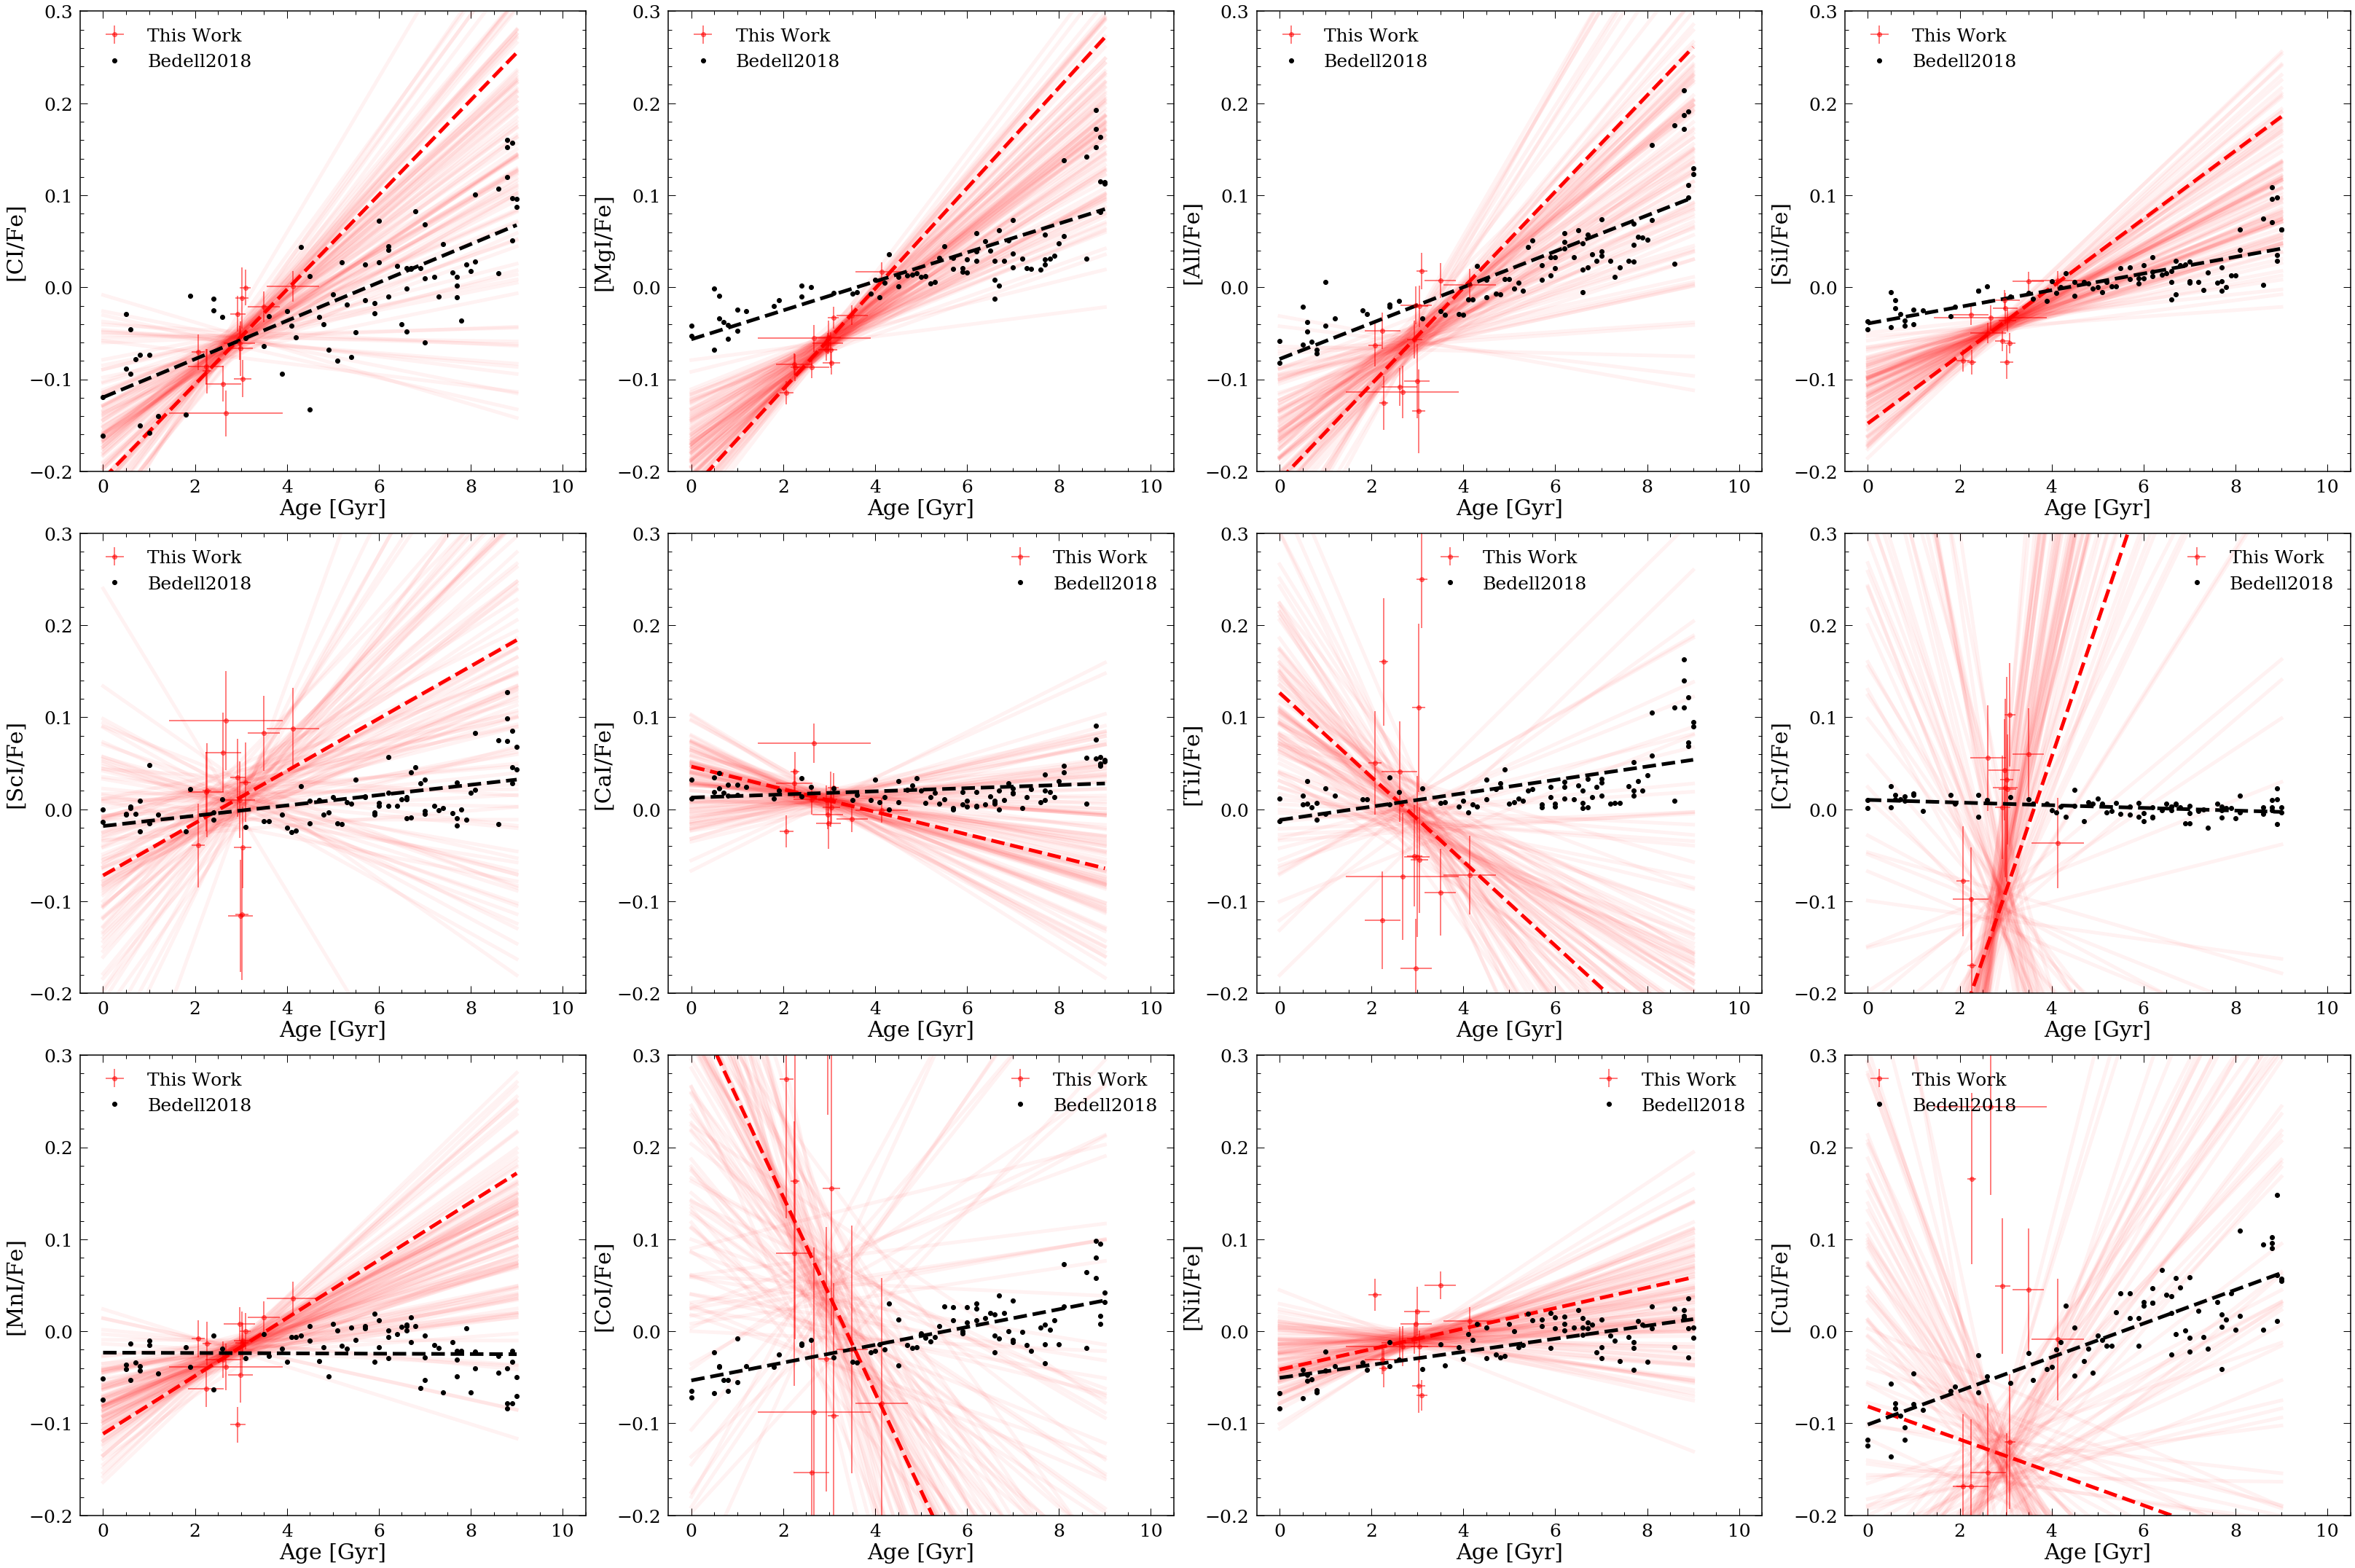

In [21]:
plt.figure(figsize=(45,30))
z=[0.75633127,-7.80094873]
df_st_prot['age_cor']=np.polyval(z,df_st_prot['age'])

plotage='age'

for i in range(len(abun_apog)):
    update_progress(i/len(abun_apog))
    df_plot=df_st_prot.loc[df_st_prot[abun_apog[i]]>-100]
    df_plot=df_plot.reset_index(drop=True)
    plt.subplot(3,4,i+1)
    
    #err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)+np.power(df_plot["age_STD_err"],2.)
    err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)
    
    
    plt.errorbar(df_plot[plotage],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],
                 xerr=df_plot["age_err"],fmt='ro',label='This Work',alpha=0.5)
    """
    plt.errorbar(df_plot['age_MAD'],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],fmt='ro',label='This Work',alpha=0.5)
    """
    
    z = np.polyfit(df_plot[plotage],df_plot[abun_apog[i]],1)
    p = np.poly1d(z)
    plt.plot(range(10),p(range(10)),'r--',linewidth=5)
        
    for k in range(100):
        new_age_mock=np.array([np.random.normal(df_plot.iloc[j][plotage],
                        df_plot.iloc[j]['age_err']) for j in range(len(df_plot))])
        new_abun_mock=np.array([np.random.normal(df_plot.iloc[j][abun_apog[i]], 
                        df_plot.iloc[j][abun_apog[i]+"_ERR"]) for j in range(len(df_plot))])
        z = np.polyfit(new_age_mock,new_abun_mock,1)
        p = np.poly1d(z)
        plt.plot(range(10),p(range(10)),'r-',linewidth=5,alpha=0.05)
    
    z = np.polyfit(df_st_md['Agemp'], df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],1)
    p = np.poly1d(z)
    
    plt.errorbar(df_st_md['Agemp'],df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],
                 fmt='ko',label='Bedell2018')
    plt.plot(range(10),p(range(10)),'k--',linewidth=5)
    
    
    plt.ylim([-0.2,0.3])
    plt.xlim([-0.5,10.5])
    plt.ylabel(abund[abun_apog[i]]+'Fe]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
plt.tight_layout()
plt.savefig('Abundances_prot.png')
    
    

Progress: [##################--] 91.7%


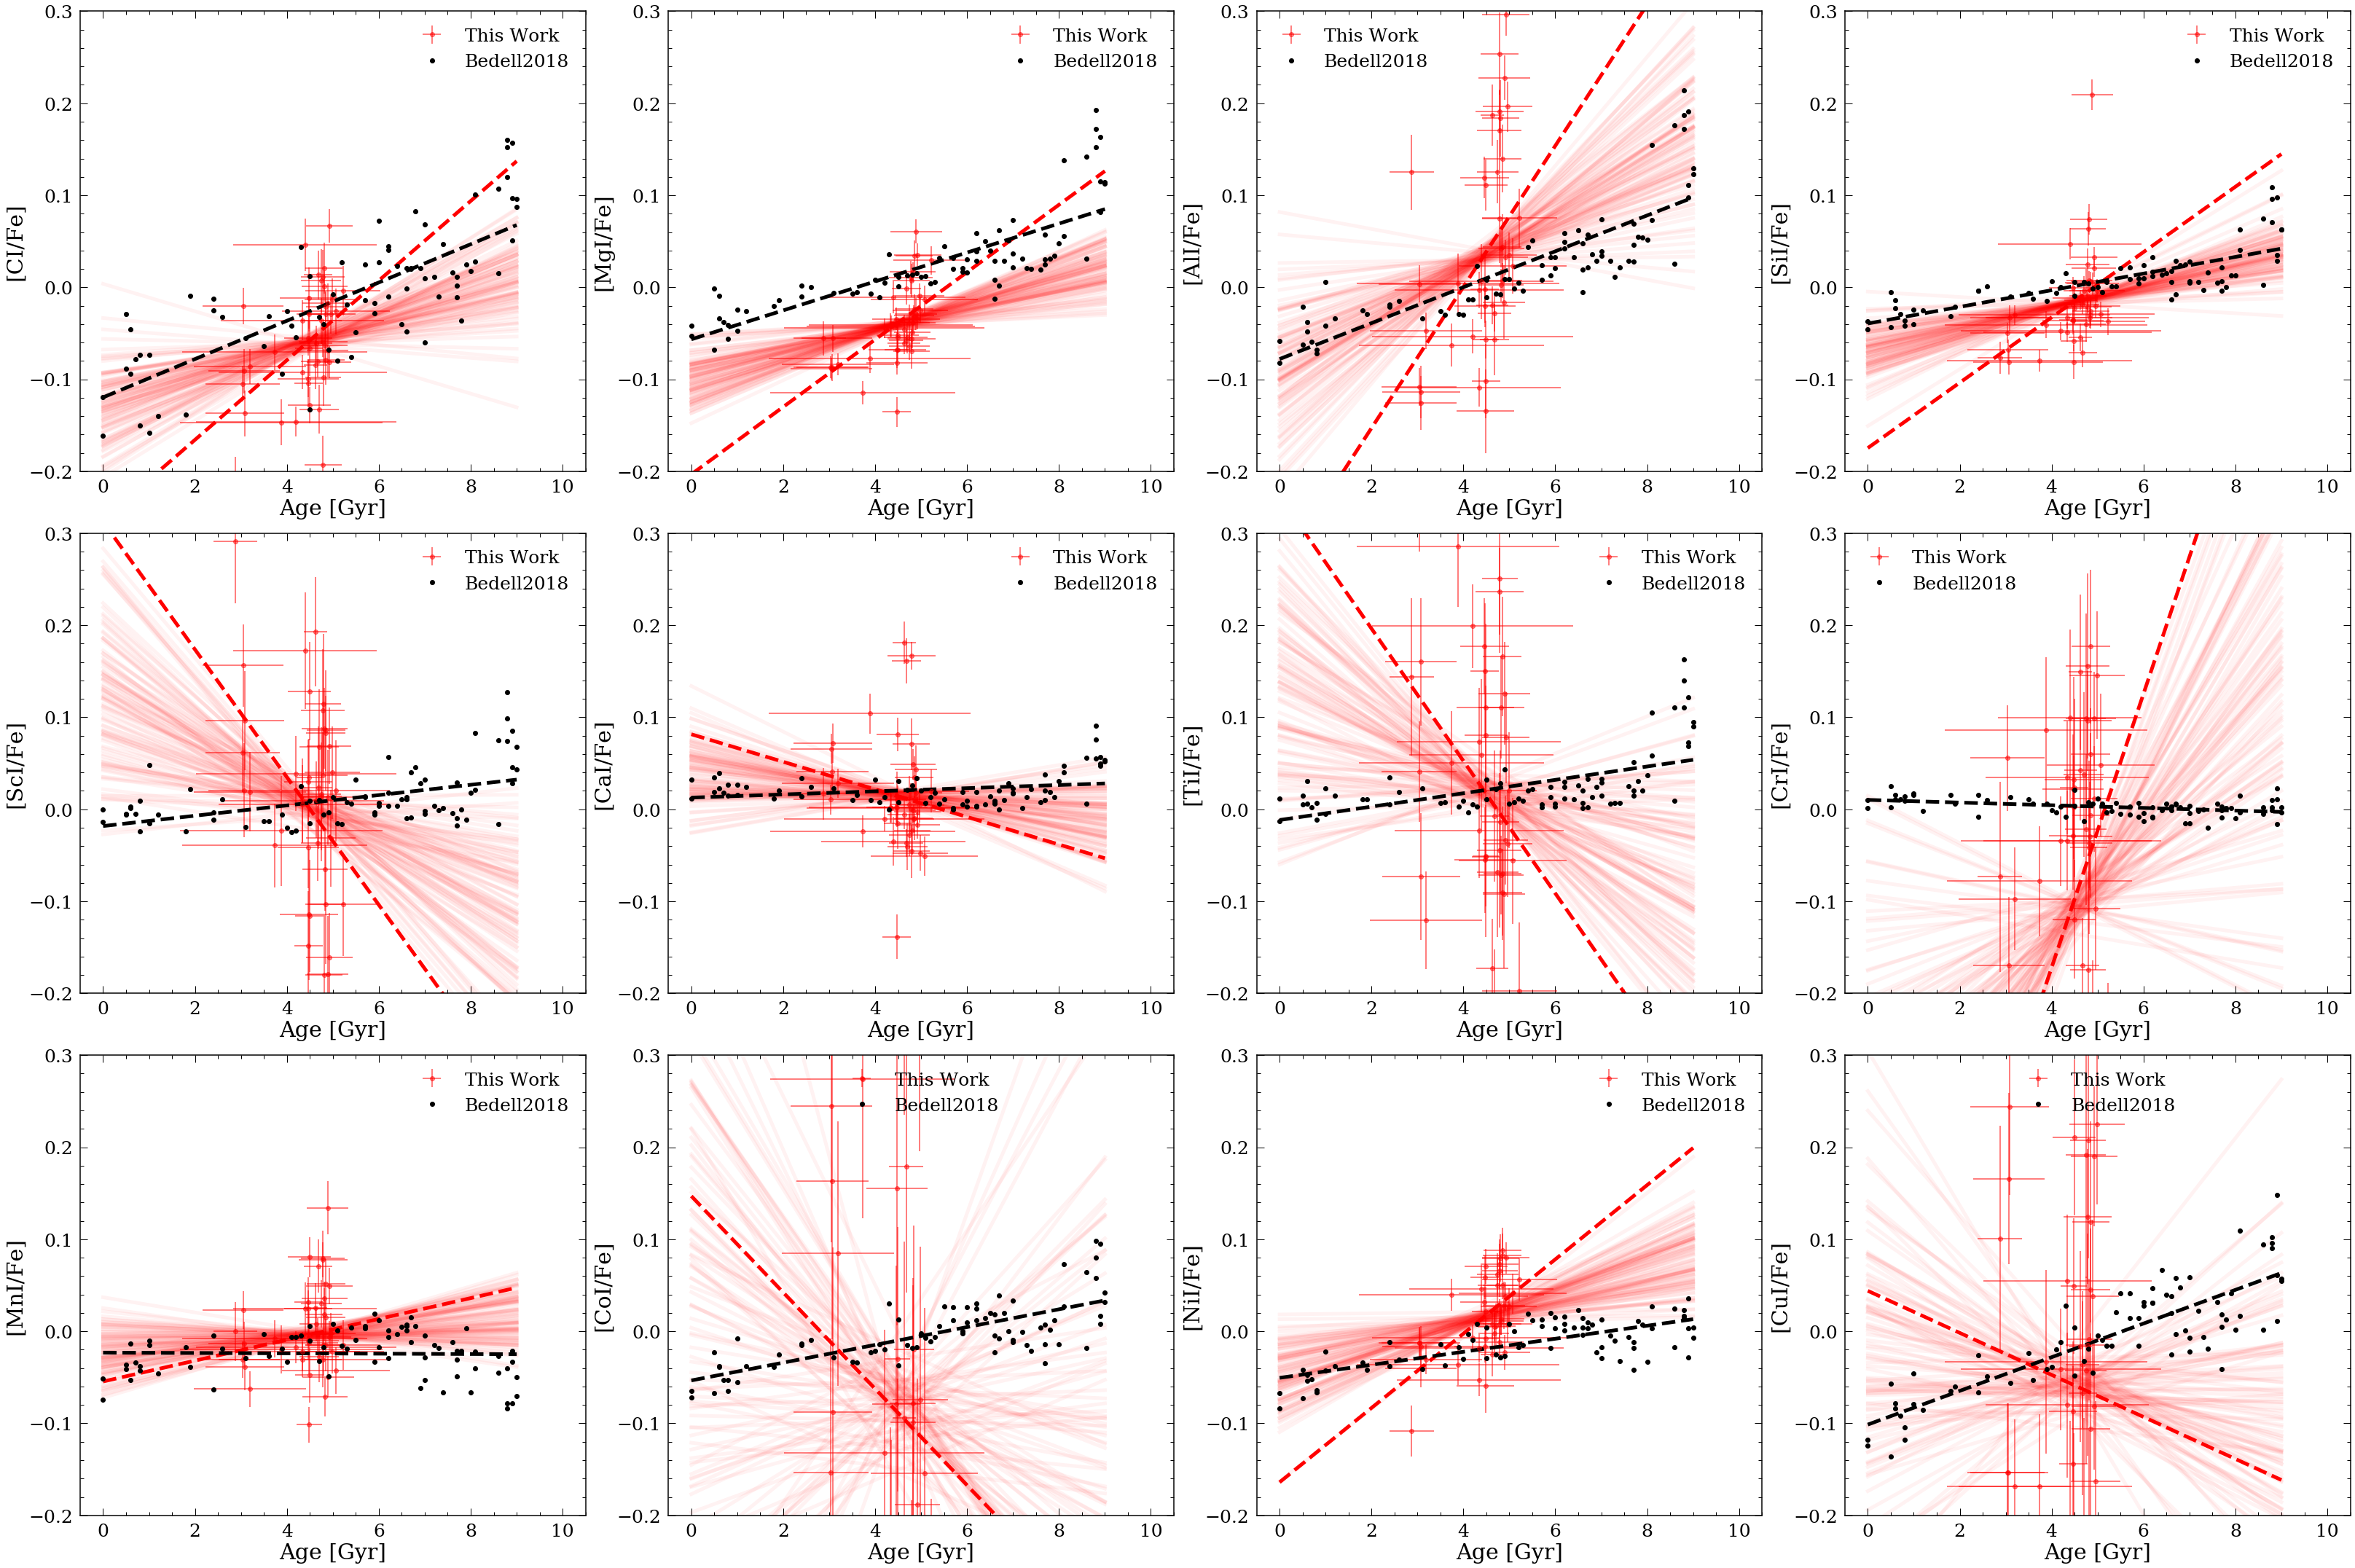

In [22]:
plt.figure(figsize=(45,30))
z=[2.04646318,-41.83900985]

df_st_rvar['age_cor']=np.polyval(z,df_st_rvar['age'])

plotage='age'

for i in range(len(abun_apog)):
    update_progress(i/len(abun_apog))
    df_plot=df_st_rvar.loc[df_st_rvar[abun_apog[i]]>-100]
    df_plot=df_plot.reset_index(drop=True)
    plt.subplot(3,4,i+1)
    
    #err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)+np.power(df_plot["age_STD_err"],2.)
    err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)
    
    
    plt.errorbar(df_plot[plotage],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],
                 xerr=df_plot["age_err"],fmt='ro',label='This Work',alpha=0.5)
    """
    plt.errorbar(df_plot['age_MAD'],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],fmt='ro',label='This Work',alpha=0.5)
    """
    
    z = np.polyfit(df_plot[plotage],df_plot[abun_apog[i]],1)
    p = np.poly1d(z)
    plt.plot(range(10),p(range(10)),'r--',linewidth=5)
        
    for k in range(100):
        new_age_mock=np.array([np.random.normal(df_plot.iloc[j][plotage],
                        df_plot.iloc[j]['age_err']) for j in range(len(df_plot))])
        new_abun_mock=np.array([np.random.normal(df_plot.iloc[j][abun_apog[i]], 
                        df_plot.iloc[j][abun_apog[i]+"_ERR"]) for j in range(len(df_plot))])
        z = np.polyfit(new_age_mock,new_abun_mock,1)
        p = np.poly1d(z)
        plt.plot(range(10),p(range(10)),'r-',linewidth=5,alpha=0.05)
    
    z = np.polyfit(df_st_md['Agemp'], df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],1)
    p = np.poly1d(z)
    
    plt.errorbar(df_st_md['Agemp'],df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],
                 fmt='ko',label='Bedell2018')
    plt.plot(range(10),p(range(10)),'k--',linewidth=5)
    
    
    plt.ylim([-0.2,0.3])
    plt.xlim([-0.5,10.5])
    plt.ylabel(abund[abun_apog[i]]+'Fe]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
plt.tight_layout()
plt.savefig('Abundances_rvar.png')
    
    